In [1]:
# 加载环境变量并配置自动重载
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# 研究主管

*主管的工作很直接：将调研任务交给合适数量的子智能体。*

以下是整体调研流程：

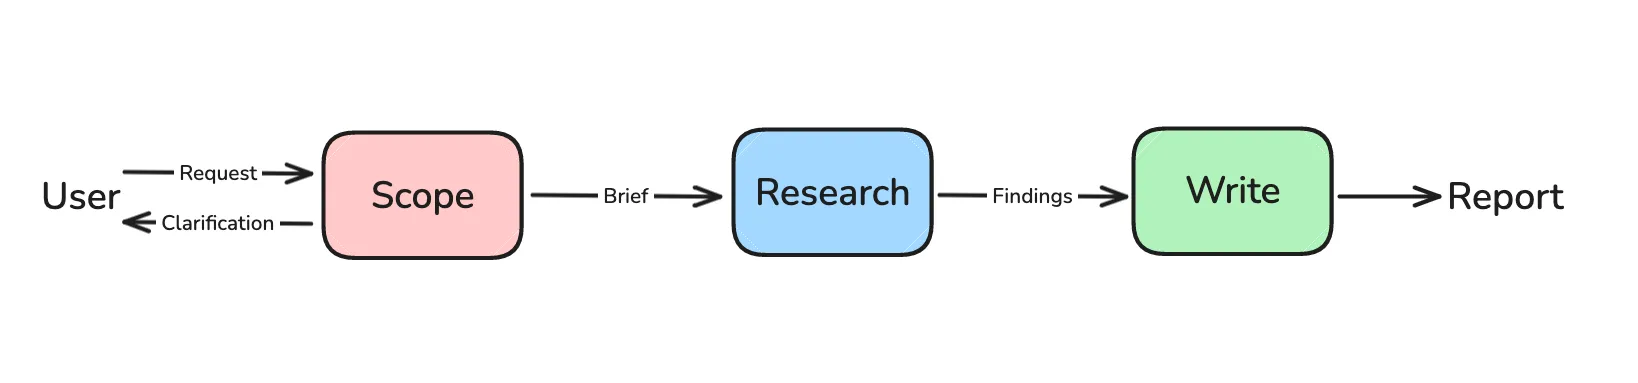

我们之前已经构建了一个可绑定自定义工具或 MCP 服务器的研究智能体。如果请求复杂、包含多个子主题会怎样？当涉及多个子主题（例如比较 A、B、C）时，单个智能体的回答质量**可能**下降，因为同一个上下文窗口需要存储并推理所有子主题对应的工具反馈。

随着上下文窗口累积来自不同子主题的工具调用，[各种失败模式](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html)，如[上下文冲突](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html)，都会变得常见。正如 [Anthropic 的博文](https://www.anthropic.com/engineering/built-multi-agent-research-system) 所述，多智能体系统可以让每个子主题交给独立的子智能体，并拥有各自隔离的上下文窗口。我们将构建一个系统，由主管判断研究简报能否拆分成独立子主题，并将它们分派给具备隔离上下文的子智能体。

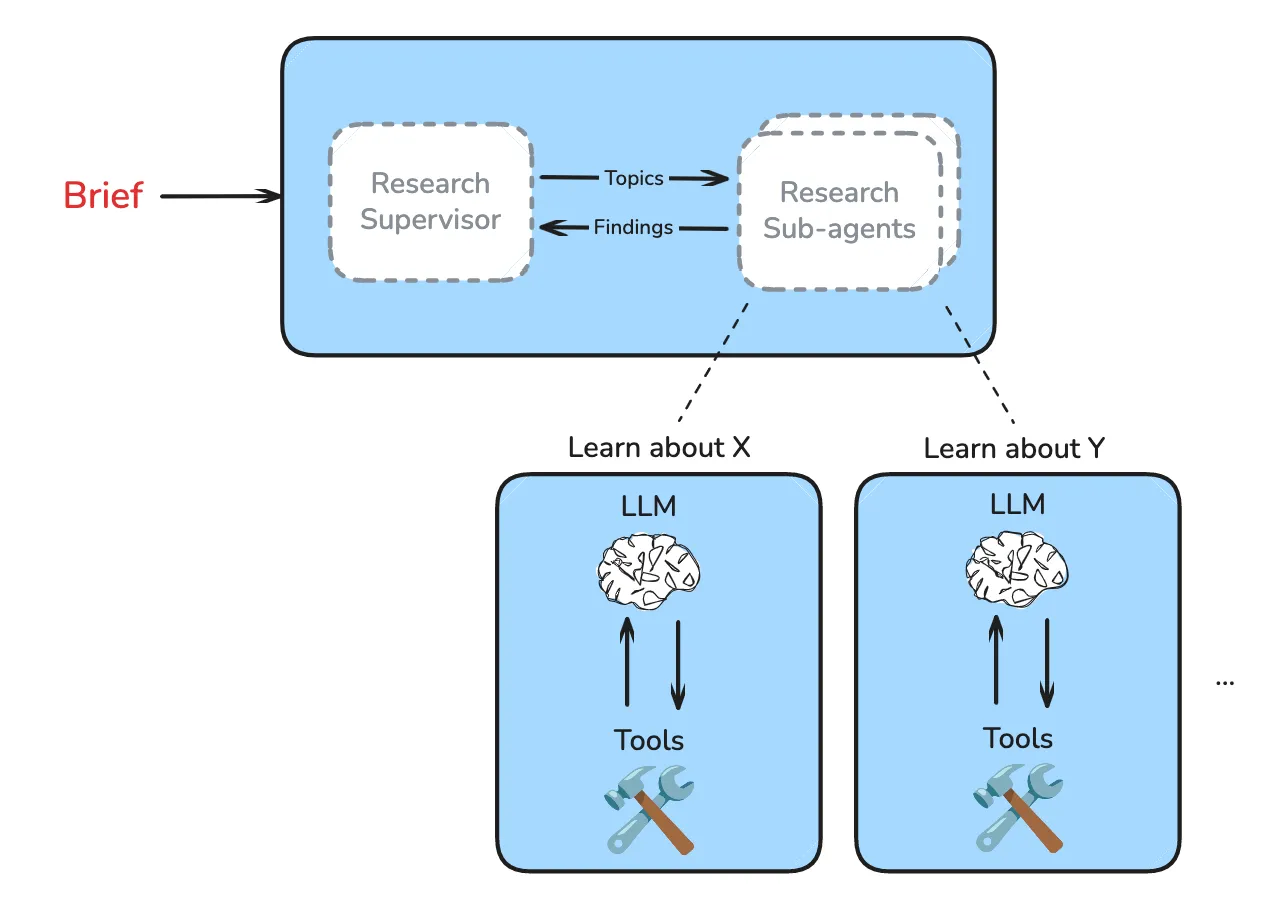

### 提示词

现在，我们来为主管设计提示词，遵循之前讨论的原则，并加入[研究领域](https://www.anthropic.com/engineering/built-multi-agent-research-system)中的一些经验。

#### 1. 像智能体一样思考
你会如何指导一位新同事？
- **仔细阅读问题** —— 用户具体需要什么信息？
- **决定如何分派调研** —— 仔细思考问题，判断是否存在可以并行探索的独立方向。
- **每次调用 ConductResearch 后暂停评估** —— 我已经可以回答了吗？还缺什么？

#### 2. 具体的启发式（用于任务分派）
用**硬性限制**避免调研智能体无限制地调用工具：
- **优先考虑单智能体** —— 仅在用户需求存在明显并行机会时才拆分，多数情况下保持简单。
- **能够自信回答时就停下** —— 不要为了完美无限制地委派任务。
- **限制工具调用次数** —— 如果找不到合适来源，最多调用 ConductResearch 3 次后必须停止。

#### 3. 展示思考过程
在调用 ConductResearch 之前，使用 think_tool 规划方案：
- 任务能否拆解成更小的子任务？

每次 ConductResearch 之后，使用 think_tool 分析结果：
- 我找到了哪些关键信息？ 
- 还缺什么？
- 我是否已经具备全面回答所需的材料？
- 应该继续搜索还是给出答案？

#### 4. 扩展规则
简单的事实查询、列表和排序任务可以使用单个子智能体。
- *示例*：列出旧金山排名前十的咖啡店 -> 使用 1 个子智能体

如果用户请求中出现比较关系，可以为比较的每个元素分配一个子智能体。
- *示例*：比较 OpenAI、Anthropic、DeepMind 的 AI 安全策略 -> 使用 3 个子智能体
- 将明确、独立、没有重叠的子主题分派出去

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

### 状态

主管的状态负责统筹整体调研，而研究员的状态处理各自的具体任务。

In [3]:
%%writefile ../cn-src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # 与主管协同决策时交换的消息
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # 指导整体研究方向的详细研究简报
    research_brief: str
    # 已整理成结构化、可用于最终报告的笔记
    notes: Annotated[list[str], operator.add] = []
    # 记录已执行调研轮数的计数器
    research_iterations: int = 0
    # 子智能体调研阶段收集的原始笔记
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../cn-src/deep_research_from_scratch/state_multi_agent_supervisor.py


### 多智能体 

现在我们来定义智能体。多智能体系统由多个协同工作的智能体组成。其主要优势是上下文隔离，这一点在[《智能体的上下文工程》](https://blog.langchain.com/context-engineering-for-agents/)中已有讨论。 

In [4]:
%%writefile ../cn-src/deep_research_from_scratch/multi_agent_supervisor.py

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio

from typing_extensions import Literal

# from langchain.chat_models import init_chat_model
from langchain_community.chat_models import ChatTongyi
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# 确保在 Jupyter 环境下具备异步兼容性
try:
    import nest_asyncio
    # 仅在 Jupyter/IPython 环境中生效
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it


# ===== 配置 =====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
# supervisor_model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
supervisor_model = ChatTongyi(model="qwen3-max")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# 系统常量
# 单个研究智能体允许的最大工具调用轮数
# 防止产生死循环并控制每个主题的调研深度
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

# 主管可同时启动的研究智能体上限
# 该值会传入 lead_researcher_prompt 以限制并行任务
max_concurrent_researchers = 3

# ===== 主管节点 =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # 根据当前日期与约束构造系统消息
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # 决策下一步调研动作
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # 初始化变量以保持单一路径返回
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # Default next step
    should_end = False
    
    # 优先检查退出条件
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        # 在决定下一步前执行完所有工具调用
        try:
            # 将 think_tool 调用与 ConductResearch 调用分开
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # 处理 think_tool 调用（同步）
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # 处理 ConductResearch 调用（异步）
            if conduct_research_calls:
                # 启动并行研究智能体
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # 等待所有调研任务完成
                tool_results = await asyncio.gather(*coros)

                # 将调研结果整理为工具消息
                # 每个子智能体都会在 result["compressed_research"] 中返回压缩后的研究结果
                # 将压缩结果写入 ToolMessage 内容，便于后续使用
                # 主管之后可通过 get_notes_from_tool_calls() 读取这些信息
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # 汇总全部调研得到的原始笔记
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    # 在单一返回点统一更新状态
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== 构建图结构 =====

# 构建主管图
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

Overwriting ../cn-src/deep_research_from_scratch/multi_agent_supervisor.py


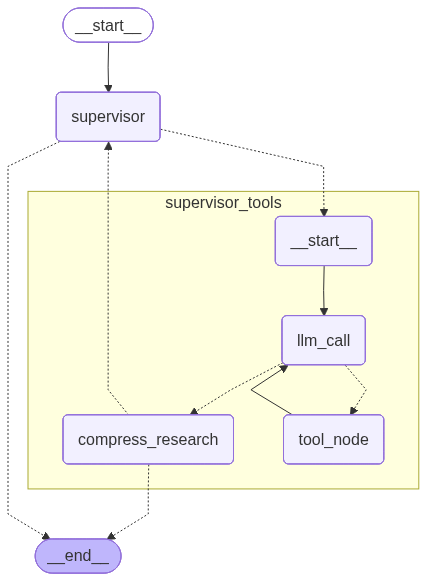

In [5]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# 展示智能体结构
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# 运行多智能体主管智能体
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭──────────────────────────────────────────────────── 🧑 用户 ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 工具调用：think_tool                                                                                         │
│    参数：{                                                                                                      │
│   "reflection": "The user wants a ranking of the best coffee shops in San Francisco based specifically on       │
│ coffee quality, using primary sources like official websites, expert reviews (e.g., Coffee Review, Specialty    │
│ Coffee Association), and customer feedback from Google/Yelp that focuses on coffee quality.\n\nThis is a        │
│ focused, single-topic research question: identify and evaluate San Francisco coffee shops by coffee quality.    │
│ There's no need for parallel research since it's essentially a list/ranking task based on one criterion.\n\nI   │
│ should delegate a single research task that captures all the user's requirements:\n- Geographic scope: San      │
│ Francisco\n- Primary criterion: coffee quality only\n- Acceptable evaluation methods: expert reviews,           │
│ certifications, customer ratings focused on coffee\n- Preferred sources: official websites, Coffee Review,      │
│ Specialty Coffee Association, Google/Yelp (with emphasis on coffee-specific feedback)\n- Time frame: latest     │
│ available data as of July 2025\n\nThe research agent should return a well-supported list or ranking with        │
│ evidence from the specified sources."                                                                           │
│ }                                                                                                               │
│    ID：call_fb08c9e910da42d399fcb7fd                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 🔧 工具输出 ──────────────────────────────────────────────────╮
│ Reflection recorded: The user wants a ranking of the best coffee shops in San Francisco based specifically on   │
│ coffee quality, using primary sources like official websites, expert reviews (e.g., Coffee Review, Specialty    │
│ Coffee Association), and customer feedback from Google/Yelp that focuses on coffee quality.                     │
│                                                                                                                 │
│ This is a focused, single-topic research question: identify and evaluate San Francisco coffee shops by coffee   │
│ quality. There's no need for parallel research since it's essentially a list/ranking task based on one          │
│ criterion.                                                                                                      │
│                                                                                                                 │
│ I should delegate a single research task that captures all the user's requirements:                             │
│ - Geographic scope: San Francisco                                                                               │
│ - Primary criterion: coffee quality only                                                                        │
│ - Acceptable evaluation methods: expert reviews, certifications, customer ratings focused on coffee             │
│ - Preferred sources: official websites, Coffee Review, Specialty Coffee Association, Google/Yelp (with emphasis │
│ on coffee-specific feedback)                                                                                    │
│ - Time frame: latest available data as of July 2025                                                             │
│                                                                                                                 │
│ The research agent should return a well-supported list or ranking with evidence from the specified sources.     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 工具调用：ConductResearch                                                                                    │
│    参数：{                                                                                                      │
│   "research_topic": "Identify and rank the best coffee shops in San Francisco based specifically on coffee      │
│ quality as of July 2025. Focus exclusively on coffee quality as the primary evaluation criterion, disregarding  │
│ factors like ambiance, location, wifi, or food options unless they directly impact perceived coffee quality.    │
│ Use primary sources including: official coffee shop websites, expert coffee review organizations (such as       │
│ Coffee Review and Specialty Coffee Association), and customer feedback from Google Reviews and Yelp that        │
│ specifically mentions coffee quality. Compile a well-supported list or ranking with evidence from these         │
│ sources, prioritizing recent data and specific mentions of coffee characteristics, bean quality, brewing        │
│ methods, and roasting expertise."                                                                               │
│ }                                                                                                               │
│    ID：call_2fb291c93ec84319ae902661                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 🔧 工具输出 ──────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. `tavily_search` with query: "best coffee shops in San Francisco by coffee quality July 2025 Coffee Review    │
│ Specialty Coffee Association"                                                                                   │
│ 2. `tavily_search` with query: "Saint Frank Coffee San Francisco coffee quality bean sourcing roasting methods  │
│ expert reviews Coffee Review Specialty Coffee Association"                                                      │
│ 3. `tavily_search` with query: "San Francisco coffee roasters quality ranking Coffee Review Specialty Coffee    │
│ Association Blue Bottle Ritual Coffee Wrecking Ball"                                                            │
│ 4. `tavily_search` with query: "San Francisco coffee shops Google Reviews Yelp customer feedback coffee quality │
│ bean quality brewing methods 2025"                                                                              │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ The webpage titled "The Best Coffee Shops in San Francisco in 2025 (Ranking)" ranks Saint Frank Coffee as the   │
│ top coffee shop in San Francisco for 2025, giving it an overall score of 8.0 out of 10 [1]. Located in Russian  │
│ Hill at 2340 Polk St, the shop is praised for its friendly staff, high-quality coffee, and inviting atmosphere  │
│ [1]. Specific ratings include 8.5 for both Espresso ($4.00) and Cappuccino ($5.50), 8.0 for its Almond          │
│ Croissant ($5.75), 8.5 for Atmosphere, and 9.0 for Music [1]. The author, Damian, notes that the review is a    │
│ subjective opinion and encourages readers to explore and form their own judgments [1]. The article is part of a │
│ series reviewing coffee shops in major cities like Chicago, Cape Town, Pittsburgh, and Los Angeles [1].         │
│                                                                                                                 │
│ "The first coffee shop I visited in San Francisco on my last trip, after research I decided to go to Saint      │
│ Frank Coffee and it was the jackpot! Super friendly staff, amazing coffee, and ambiance that make you want to   │
│ spend there entire day!" [1]. "I hope you will enjoy exploring those great coffee shops, and remember that it   │
│ is my subjective opinion, your taste can be different than mine and you can find some coffee or places better   │
│ or worse." [1]. "Most importantly enjoy the journey of exploring the world of San Francisco Coffee Shops." [1]. │
│                                                                                                                 │
│ The guide "The Best Coffee Shops In SF - San Francisco" presents a curated list of the best coffee shops in San │
│ Francisco, highlighting a diverse range of cafes known for their exceptional coffee, unique atmospheres, and    │
│ often standout food [2]. Authored by Julia Chen, Lani Conway, Ricky Rodriguez, and Patrick Wong for The         │
│ Infatuation, the guide features spots across various neighborhoods including Richmond, SoMa, Bernal Heights,    │
│ and the Mission [2]. It includes a mix of tiny takeout coun

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 工具调用：think_tool                                                                                         │
│    参数：{                                                                                                      │
│   "reflection": "I have received comprehensive research findings about San Francisco coffee shops with a focus  │
│ on coffee quality. Let me analyze what I've found:\n\n**Key Findings:**\n1. **Saint Frank Coffee** emerges as   │
│ the most consistently top-ranked coffee shop across multiple sources:\n   - Ranked #1 in \"The Best Coffee      │
│ Shops in San Francisco in 2025\" with an 8.0/10 overall score\n   - Praised specifically for coffee quality,    │
│ ethical sourcing, and transparency (includes origin postcards)\n   - High customer ratings (4.3-4.5 stars) with │
│ specific mentions of \"best coffee in the city\"\n   - Recognized by The Daily Meal as top 3 in America and     │
│ Thrillist as top 21 in America\n\n2. **Other consistently mentioned high-quality coffee shops:**\n   -          │
│ **Wrecking Ball Coffee Roasters** - historically significant (birthplace of \"third wave\" coffee terminology), │
│ mentioned in multiple top lists\n   - **Sightglass Coffee** - highly rated (4.0 stars, 2.2k reviews), noted for │
│ roasting operations and quality\n   - **Andytown Coffee Roasters** - excellent ratings (4.5 stars, 1.1k         │
│ reviews)\n   - **Ritual Coffee Roasters** - mentioned in expert lists\n   - **Four Barrel Coffee** - recognized │
│ for quality and sourcing practices\n   - **Blue Bottle Coffee** - consistently mentioned in top lists\n   -     │
│ **Caffe Trieste** - historic institution (first espresso-based coffee shop on West Coast)\n\n3. **Sources used  │
│ align with user requirements:**\n   - Recent data (2025 updates from Eater SF, Damian's blog)\n   - Customer    │
│ feedback from Yelp and Google-equivalent sources\n   - Expert curation from The Infatuation, Eater SF\n   -     │
│ Some mention of certifications/reputation (The Daily Meal, Thrillist rankings)\n\n**Gaps to consider:**\n-      │
│ Limited direct mentions of Specialty Coffee Association certifications or Coffee Review specific ratings\n-     │
│ Most sources combine coffee quality with other factors (though coffee quality is emphasized)\n- The research    │
│ provides good coverage but could benefit from more specific coffee quality metrics\n\nHowever, the findings are │
│ quite comprehensive and consistently point to the same top-tier coffee shops, with Saint Frank Coffee appearing │
│ as the clear leader specifically for coffee quality. The evidence comes from multiple reputable sources with    │
│ recent 2025 data, customer reviews focusing on coffee taste/quality, and expert curation.\n\nGiven the          │
│ consistency across sources and the focus on coffee quality in the feedback, I believe I have sufficient         │
│ information to provide a well-supported ranking. The user's primary requirement was coffee quality as the main  │
│ criterion, and the research shows clear consensus on the top performers."                                       │
│ }                                                                                                               │
│    ID：call_e47060e3137f427ba0290bc3                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 🔧 工具输出 ──────────────────────────────────────────────────╮
│ Reflection recorded: I have received comprehensive research findings about San Francisco coffee shops with a    │
│ focus on coffee quality. Let me analyze what I've found:                                                        │
│                                                                                                                 │
│ **Key Findings:**                                                                                               │
│ 1. **Saint Frank Coffee** emerges as the most consistently top-ranked coffee shop across multiple sources:      │
│    - Ranked #1 in "The Best Coffee Shops in San Francisco in 2025" with an 8.0/10 overall score                 │
│    - Praised specifically for coffee quality, ethical sourcing, and transparency (includes origin postcards)    │
│    - High customer ratings (4.3-4.5 stars) with specific mentions of "best coffee in the city"                  │
│    - Recognized by The Daily Meal as top 3 in America and Thrillist as top 21 in America                        │
│                                                                                                                 │
│ 2. **Other consistently mentioned high-quality coffee shops:**                                                  │
│    - **Wrecking Ball Coffee Roasters** - historically significant (birthplace of "third wave" coffee            │
│ terminology), mentioned in multiple top lists                                                                   │
│    - **Sightglass Coffee** - highly rated (4.0 stars, 2.2k reviews), noted for roasting operations and quality  │
│    - **Andytown Coffee Roasters** - excellent ratings (4.5 stars, 1.1k reviews)                                 │
│    - **Ritual Coffee Roasters** - mentioned in expert lists                                                     │
│    - **Four Barrel Coffee** - recognized for quality and sourcing practices                                     │
│    - **Blue Bottle Coffee** - consistently mentioned in top lists                                               │
│    - **Caffe Trieste** - historic institution (first espresso-based coffee shop on West Coast)                  │
│                                                                                                                 │
│ 3. **Sources used align with user requirements:**                                                               │
│    - Recent data (2025 updates from Eater SF, Damian's blog)                                                    │
│    - Customer feedback from Yelp and Google-equivalent sources                                                  │
│    - Expert curation from The Infatuation, Eater SF                                                             │
│    - Some mention of certifications/reputation (The Daily Meal, Thrillist rankings)                             │
│                                                                                                                 │
│ **Gaps to consider:**                                                                                           │
│ - Limited direct mentions of Specialty Coffee Association certifications or Coffee Review specific ratings      │
│ - Most sources combine coffee quality with other factors (though coffee quality is emphasized)                  │
│ - The research provides good coverage but could benefit from more specific coffee quality metrics               │
│                                                                                                                 │
│ However, the findings are quite comprehensive and consistently point to the same top-tier coffee shops, with    │
│ Saint Frank Coffee appearing as the clear leader specifically for coffee quality. The evidence comes from       │
│ multiple reputable sources with recent 2025 data, customer 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 工具调用：ResearchComplete                                                                                   │
│    参数：{}                                                                                                     │
│    ID：call_4f3caedbd76e433f839f643b                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

我们可以在[这里](https://smith.langchain.com/public/99eaaecd-fd9a-4ead-8eed-abdfe4ab9288/r)查看追踪记录。

### LangGraph Studio

和之前一样，我们也可以用 LangGraph Studio 来可视化该智能体。 

该智能体已经添加到 `langgraph.json` 文件中，你可以在下拉菜单选择 `research_agent_supervisor`：

```
"research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
```

运行以下命令即可启动 Studio：

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## 评估

当子主题彼此独立时，多智能体的显著优势就是上下文隔离。正如我们在[博客](https://blog.langchain.com/open-deep-research/)中所述： 

> 我们的实验发现，当请求包含多个子主题（例如比较 A、B、C）时，单智能体的回答质量会下降。直觉很简单：一个上下文窗口需要存储并推理所有子主题的工具反馈，而这些反馈往往非常占用 token。随着上下文堆积来自不同子主题的工具调用，各种失败模式（例如上下文冲突）就会频繁出现。

但我们也要避免在不必要的情况下创建子智能体：

> 主管可以通过选择性地启动子智能体来调节所需的调研深度。提示词会用启发式帮助主管判断何时需要并行调研、何时单线程足够。我们的深度调研智能体可以灵活选择是否要并行。

接下来我们构建几个测试，确保只有在合适的场景下才并行化。

In [7]:
# 评估用示例消息，包含 think_tool 与工具消息
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [8]:
import os
from langsmith import Client

# 初始化客户端
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# 创建数据集
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

现在我们可以运行评估。

In [ ]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

在第一个示例中，我们让智能体比较不同的产品。

这类问题非常适合并行调研，我们期望智能体能对每个实验室分别深入研究，再在撰写报告时综合结果。

第二个示例要求智能体给出曼哈顿切尔西区的最佳餐厅。 

这里智能体只需沿着单一线索调研，查看那些罗列高评分餐厅的网站即可。 

对于这种排名任务，并没有显而易见的并行机会。